In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import journal_figure
from scipy.stats import spearmanr
import json

In [2]:
from scipy.stats import median_abs_deviation as mad

def nanmad(var):
    return mad(np.nan_to_num(var))

In [3]:
import h5py

with h5py.File('coco_indices_in_python.mat', 'r') as f:
    print(list(f.keys()))  #
    indices_coco = f['coco_indices_in_python'][:]

indices_coco = np.array(indices_coco.squeeze(), dtype=int)

['coco_indices_in_python']


In [4]:
all_models = ["resnet18", "alexnet", "convnext", "vgg19", "resnet50", "vgg16", "vit", "vit_ssl", "resnet_ssl", "efficientnet", "swin"]

In [5]:
selected_indices = [0, 2, 22, 25, 41, 44, 63, 68, 81, 85, 101, 120, 122, 140, 142, 161, 180, 187]
selected_indices_v2 = [8, 18, 24, 31, 46, 54, 70, 76, 86, 87, 102, 103, 105, 123, 130, 143, 144, 163, 172, 173, 191, 199]
all_selected_indices = list(sorted(selected_indices + selected_indices_v2))

no40 = ~np.isin(np.arange(len(indices_coco)), all_selected_indices)
indices_no40 = np.arange(len(indices_coco))[no40]

all_split1 = []
all_split2 = []
for r in range(20):
    indices = np.random.choice(160, 80, replace=False)
    split1 = indices_no40[indices]
    split2 = np.setdiff1d(indices_no40, split1)

    all_split1.append(list(sorted(split1)))
    all_split2.append(list(sorted(split2)))

In [6]:
best_ref_pemi_clean_scores = {}
best_ref_pemi_clean = {}
    
for target_model_name in all_models:
    score_accross_reps = []
    for r in range(20):
        clean_corrs = []
        i1_clean_target = np.load(f"./i1s_clean/i1_{target_model_name}.npy")[all_split1[r]]
        for ref_model_name in all_models:
            i1_clean_ref = np.load(f"./i1s_clean/i1_{ref_model_name}.npy")[all_split1[r]]
            if ref_model_name == target_model_name:
                clean_corrs.append(np.nan)
            else:
                clean_corrs.append(spearmanr(i1_clean_target, i1_clean_ref)[0])
        score_accross_reps.append(clean_corrs)

    score_accross_reps = np.array(score_accross_reps)
    
    score_accross_reps = np.nanmean(score_accross_reps, axis=0)
    best_ref_pemi_clean_score = np.nanmax(score_accross_reps)
            
    best_ref_pemi_clean_scores[target_model_name] = best_ref_pemi_clean_score
    best_ref_pemi_clean[target_model_name] = all_models[np.nanargmax(score_accross_reps)]

/var/folders/h2/8tj3snsd0wj1qzvdlg5_17y00000gn/T/ipykernel_86067/1441377816.py:19: RuntimeWarning: Mean of empty slice
  score_accross_reps = np.nanmean(score_accross_reps, axis=0)


In [7]:
print(best_ref_pemi_clean)

{'resnet18': 'vgg16', 'alexnet': 'resnet_ssl', 'convnext': 'swin', 'vgg19': 'vgg16', 'resnet50': 'vgg19', 'vgg16': 'vgg19', 'vit': 'convnext', 'vit_ssl': 'vit', 'resnet_ssl': 'alexnet', 'efficientnet': 'resnet50', 'swin': 'convnext'}


In [8]:
best_ref_pemi_clean_scores_test = {}
best_ref_pemi_clean_errors_test = {}
for target_model_name in all_models:
    clean_corrs = []
    for r in range(20):
        
        i1_clean_target = np.load(f"./i1s_clean/i1_{target_model_name}.npy")[all_split2[r]]
        i1_clean_ref = np.load(f"./i1s_clean/i1_{best_ref_pemi_clean[target_model_name]}.npy")[all_split2[r]]
        corr = spearmanr(i1_clean_target, i1_clean_ref)[0]
        clean_corrs.append(corr)
    best_ref_pemi_clean_scores_test[target_model_name] = np.nanmean(np.array(clean_corrs))
    best_ref_pemi_clean_errors_test[target_model_name] = np.nanstd(np.array(clean_corrs))

In [9]:
emis_colors = list(reversed(['#590d22', '#800f2f', '#a4133c', '#c9184a', '#ff4d6d', '#ff617e', '#ff758f', '#ff8fa3', '#ffb3c1', '#ffccd5']))


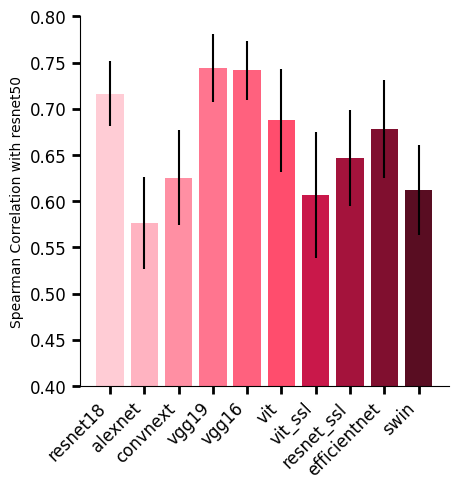

In [10]:
target = "resnet50"
clean_corrs = np.zeros((20, len(all_models)))+np.nan
for r in range(20):
    i1_clean_target = np.load(f"./i1s_clean/i1_{target}.npy")[all_split2[r]]
    for i, ref_model_name in enumerate(all_models):
        i1_clean_ref = np.load(f"./i1s_clean/i1_{ref_model_name}.npy")[all_split2[r]]
        if ref_model_name == target:
            clean_corrs[r, i] = np.nan
            continue
        else:
            r0 = spearmanr(i1_clean_target, i1_clean_ref)[0]
            clean_corrs[r, i] = r0

all_models_ref = all_models.copy()
all_models_ref.remove(target)
clean_corrs = clean_corrs[:, np.array([m != target for m in all_models])]

plt.bar(range(len(all_models)-1), np.nanmean(clean_corrs, axis=0), yerr=np.nanstd(clean_corrs, axis=0), color=emis_colors)
plt.xticks(range(len(all_models)-1), all_models_ref, rotation=45, ha='right')
plt.ylabel(f'Spearman Correlation with {target}')
plt.ylim(0.4, 0.8)
journal_figure()

In [11]:
method_names = ['Saliency', 'NoiseTunnel_Saliency', 'Deconvolution', 'InputXGradient', 'GuidedBackprop', 'GradientShap', 'Occlusion', 'IntegratedGradients', 'NoiseTunnel_Deconvolution', 'NoiseTunnel_InputXGradient', 'FeatureAblation', 'FeaturePermutation']

In [12]:
res_proxy = np.zeros((20, len(all_models), 12))
res_ground_truth = np.zeros((20, len(all_models), 12))
for r in range(20):
    for t, target_model_name in enumerate(all_models):
        ref_model_name = best_ref_pemi_clean[target_model_name]

        temp_p = []
        for m, method_name in enumerate(method_names):
            
            response_dir = f'../../XAI/behavioral_responses_v2/{ref_model_name}/{method_name}'
            
            i1_file_target_pemi = f'{response_dir}/75/{target_model_name}_i1.json'
            i1_file_ref_pemi = f'{response_dir}/75/{ref_model_name}_i1.json'
            
            with open(i1_file_target_pemi, 'r') as f:
                i1_scores_target_pemi = json.load(f)
            with open(i1_file_ref_pemi, 'r') as f:
                i1_scores_ref_pemi = json.load(f)

            i1_target = np.array(i1_scores_target_pemi['target_pEMI'])[all_split1[r]] #[~np.isin(np.arange(len(indices_coco)), all_selected_indices)]
            i1_ref = np.array(i1_scores_ref_pemi['target_pEMI'])[all_split1[r]] #[~np.isin(np.arange(len(indices_coco)), all_selected_indices)]

            corr_pemi = spearmanr(i1_target, i1_ref)[0]
            
            temp_p.append(corr_pemi)

        res_proxy[r, t] = np.array(temp_p)


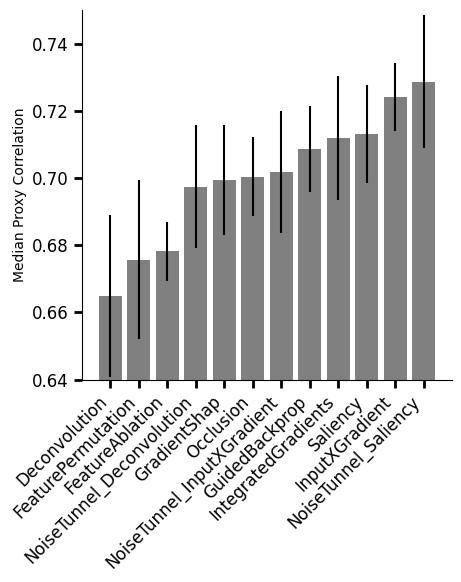

In [13]:
# Compute median across runs (r) and models (t) for each method
vals = np.median(res_proxy, axis=(0, 1))
errs = [nanmad(np.nanmean(res_proxy, axis=1)[:,t].flatten()) for t in range(len(method_names))] #/ np.sqrt(20)
errs = np.array(errs)

# Get ordering indices (ascending)
order = np.argsort(vals)

# Reorder everything
vals_sorted = vals[order]
errs_sorted = errs[order]
method_names_sorted = [method_names[i] for i in order]

# Plot
plt.bar(range(len(method_names_sorted)), vals_sorted,
        yerr=errs_sorted, color="grey")

plt.xticks(range(len(method_names_sorted)), method_names_sorted,
           rotation=45, ha='right')
plt.ylabel('Median Proxy Correlation')
plt.ylim(0.64, 0.75)
journal_figure()


In [14]:
best_method_idx = np.argmax(vals)
worst_method_idx = np.argmin(vals)

best_method = method_names[best_method_idx]
worst_method = method_names[worst_method_idx]

In [15]:
print("Best method: ", best_method, "\nWorst method: ", worst_method)

Best method:  NoiseTunnel_Saliency 
Worst method:  Deconvolution


In [16]:
percentiles = [50, 60, 65, 70, 75, 80, 85, 90, 95, 97, 98, 99]

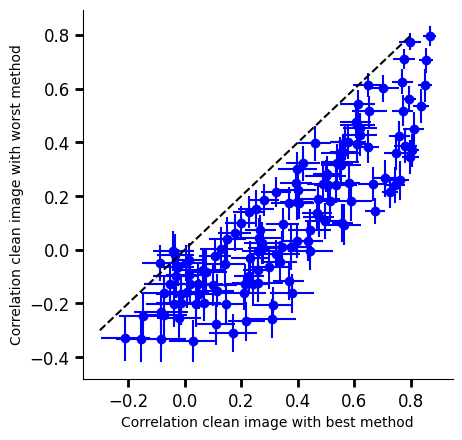

In [17]:
for t, target_model_name in enumerate(all_models):

    ref_model_name = best_ref_pemi_clean[target_model_name]
    
    for p_idx, p in enumerate(percentiles):
        corr_pemi_best_r, corr_pemi_worst_r = [], []
        for r in range(20):
            response_dir = f'../../XAI/behavioral_responses_v2/{ref_model_name}/NoiseTunnel_Saliency'
                    
            i1_file_target_pemi = f'{response_dir}/{p}/{target_model_name}_i1.json'
            i1_file_ref_pemi = f'{response_dir}/{p}/{ref_model_name}_i1.json'
            
            with open(i1_file_target_pemi, 'r') as f:
                i1_scores_target_pemi = json.load(f)
            with open(i1_file_ref_pemi, 'r') as f:
                i1_scores_ref_pemi = json.load(f)

            i1_clean_target = np.load(f"./i1s_clean/i1_{target_model_name}.npy")[all_split2[r]]  

            corr_pemi_best = spearmanr(i1_clean_target, np.array(i1_scores_ref_pemi['target_pEMI'])[all_split2[r]])[0]
            corr_pemi_best_r.append(corr_pemi_best)

            response_dir = f'../../XAI/behavioral_responses_v2/{ref_model_name}/Deconvolution'
                    
            i1_file_target_pemi = f'{response_dir}/{p}/{target_model_name}_i1.json'
            i1_file_ref_pemi = f'{response_dir}/{p}/{ref_model_name}_i1.json'
            
            with open(i1_file_target_pemi, 'r') as f:
                i1_scores_target_pemi = json.load(f)
            with open(i1_file_ref_pemi, 'r') as f:
                i1_scores_ref_pemi = json.load(f)

            i1_clean_target = np.load(f"./i1s_clean/i1_{target_model_name}.npy") [all_split2[r]] 

            corr_pemi_worst = spearmanr(i1_clean_target, np.array(i1_scores_ref_pemi['target_pEMI'])[all_split2[r]])[0]
            corr_pemi_worst_r.append(corr_pemi_worst)


        corr_pemi_best_r = np.array(corr_pemi_best_r)
        corr_pemi_worst_r = np.array(corr_pemi_worst_r)
        corr_pemi_best_m = np.nanmean(corr_pemi_best_r)
        corr_pemi_worst_m = np.nanmean(corr_pemi_worst_r)
        corr_pemi_best_e = np.nanstd(corr_pemi_best_r)
        corr_pemi_worst_e = np.nanstd(corr_pemi_worst_r)
            
        plt.scatter(corr_pemi_best_m, corr_pemi_worst_m, color="blue")
        plt.errorbar(corr_pemi_best_m, corr_pemi_worst_m, xerr=corr_pemi_best_e, yerr=corr_pemi_worst_e, color="blue")

plt.xlabel("Correlation clean image with best method")
plt.ylabel("Correlation clean image with worst method")
plt.plot([-0.3, 0.8], [-0.3, 0.8], color="black", linestyle="--")

journal_figure()

plt.show()
